In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import joblib
import warnings

# Import custom modules
import sys
sys.path.append('../src')

from utils import DataLoader
from features import (FeatureExtractor, TimeDomainFeatures, 
                     FrequencyDomainFeatures, WaveletFeatures,
                     NonlinearFeatures, RQAFeatures)

warnings.filterwarnings('ignore')


In [8]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

np.random.seed(42)

In [17]:
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed' / 'bonn'
FEATURES_DIR = PROCESSED_DIR / 'features'
FIGURES_DIR = Path('../results/figures')

# Dataset configuration
SAMPLING_RATE = 173.61  # Bonn dataset sampling rate

# Feature extraction configuration
FEATURE_CONFIG = {
    'sampling_rate': SAMPLING_RATE,
    'include_rqa': False, # Set to True to include RQA features, using False for fast extraction
    'wavelet_type': 'db4',
    'wavelet_level': 5,
    'rqa_embedding_dim': 3,
    'rqa_time_delay': 1,
    'rqa_threshold': 0.1
}

In [ ]:
# ============================================================================
# LOAD PREPROCESSED DATA
# ============================================================================

In [10]:
loader = DataLoader(data_dir='../data/processed')

# Load train/val/test splits
X_train, y_train, X_val, y_val, X_test, y_test = loader.load_bonn_splits()

print(f"\n✓ Loaded preprocessed splits:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Samples per window: {X_train.shape[1]}")
print(f"  - Duration per window: {X_train.shape[1] / SAMPLING_RATE:.2f} seconds")

Loaded Bonn dataset splits:
  - Training: (5600, 694)
  - Validation: (1200, 694)
  - Test: (1200, 694)

✓ Loaded preprocessed splits:
  - Training: (5600, 694)
  - Validation: (1200, 694)
  - Test: (1200, 694)
  - Samples per window: 694
  - Duration per window: 4.00 seconds


In [ ]:
# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

In [11]:
# Initialize feature extractor
extractor = FeatureExtractor(sampling_rate=SAMPLING_RATE)

# Extract features from one sample of each class
print("\nExtracting features from sample signals...")

# Get one seizure and one normal sample
seizure_idx = np.where(y_train == 1)[0][0]
normal_idx = np.where(y_train == 0)[0][0]

sample_seizure = X_train[seizure_idx]
sample_normal = X_train[normal_idx]

# Extract features
time_features_seizure = extractor.time_features.extract(sample_seizure)
time_features_normal = extractor.time_features.extract(sample_normal)
print(f"\nExtracted {len(time_features_seizure)} time domain features")

freq_features_seizure = extractor.freq_features.extract(sample_seizure)
freq_features_normal = extractor.freq_features.extract(sample_normal)
print(f"\nExtracted {len(freq_features_seizure)} frequency domain features")

wavelet_features_seizure = extractor.wavelet_features.extract(sample_seizure)
wavelet_features_normal = extractor.wavelet_features.extract(sample_normal)
print(f"\nExtracted {len(wavelet_features_seizure)} wavelet features")

nonlinear_features_seizure = extractor.nonlinear_features.extract(sample_seizure)
nonlinear_features_normal = extractor.nonlinear_features.extract(sample_normal)
print(f"\nExtracted {len(nonlinear_features_seizure)} nonlinear features")

if FEATURE_CONFIG['include_rqa']:
    rqa_features_seizure = extractor.rqa_features.extract(sample_seizure)
    rqa_features_normal = extractor.rqa_features.extract(sample_normal)
    print(f"\nExtracted {len(rqa_features_seizure)} RQA features")
else:
    print("RQA features disabled (set include_rqa=True to enable)")

# Get all features
all_features_seizure = extractor.extract_all(sample_seizure, include_rqa=FEATURE_CONFIG['include_rqa'])
all_features_normal = extractor.extract_all(sample_normal, include_rqa=FEATURE_CONFIG['include_rqa'])

print(f"\nTotal features per sample: {len(all_features_seizure)}")


Extracting features from sample signals...

Extracted 18 time domain features

Extracted 18 frequency domain features

Extracted 31 wavelet features

Extracted 7 nonlinear features

Extracted 7 RQA features

Total features per sample: 81


In [13]:
print("\n" + "="*80)
print("FEATURE COMPARISON: SEIZURE VS NORMAL")
print("="*80)

#Create comparison dataframe
comparison_data = []

for feature_name in all_features_seizure.keys():
    comparison_data.append({
        'Feature': feature_name,
        'Seizure': all_features_seizure[feature_name],
        'Normal': all_features_normal[feature_name],
        'Difference': all_features_seizure[feature_name] - all_features_normal[feature_name],
        'Ratio': all_features_seizure[feature_name] / (all_features_normal[feature_name] + 1e-10)
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nTop 10 features with largest absolute differences:")
print(comparison_df.nlargest(10, 'Difference')[['Feature', 'Seizure', 'Normal', 'Difference']])



FEATURE COMPARISON: SEIZURE VS NORMAL

Top 10 features with largest absolute differences:
                    Feature      Seizure       Normal  Difference
38   wavelet_level_0_energy   707.915948   343.036520  364.879428
13                   energy   908.991867   777.109357  131.882510
42   wavelet_level_1_energy   159.498181    88.194367   71.303814
60     wavelet_total_energy  1135.140231  1104.152964   30.987267
79        rqa_trapping_time    14.142389     4.563617    9.578772
76  rqa_avg_diagonal_length    10.353819     4.853831    5.499988
37      wavelet_level_0_std     4.955585     3.266392    1.689193
71        hjorth_complexity     2.745065     1.367481    1.377583
80              rqa_entropy     4.518465     3.158275    1.360190
5                       max     4.142279     2.988566    1.153713



Creating feature comparison visualizations...


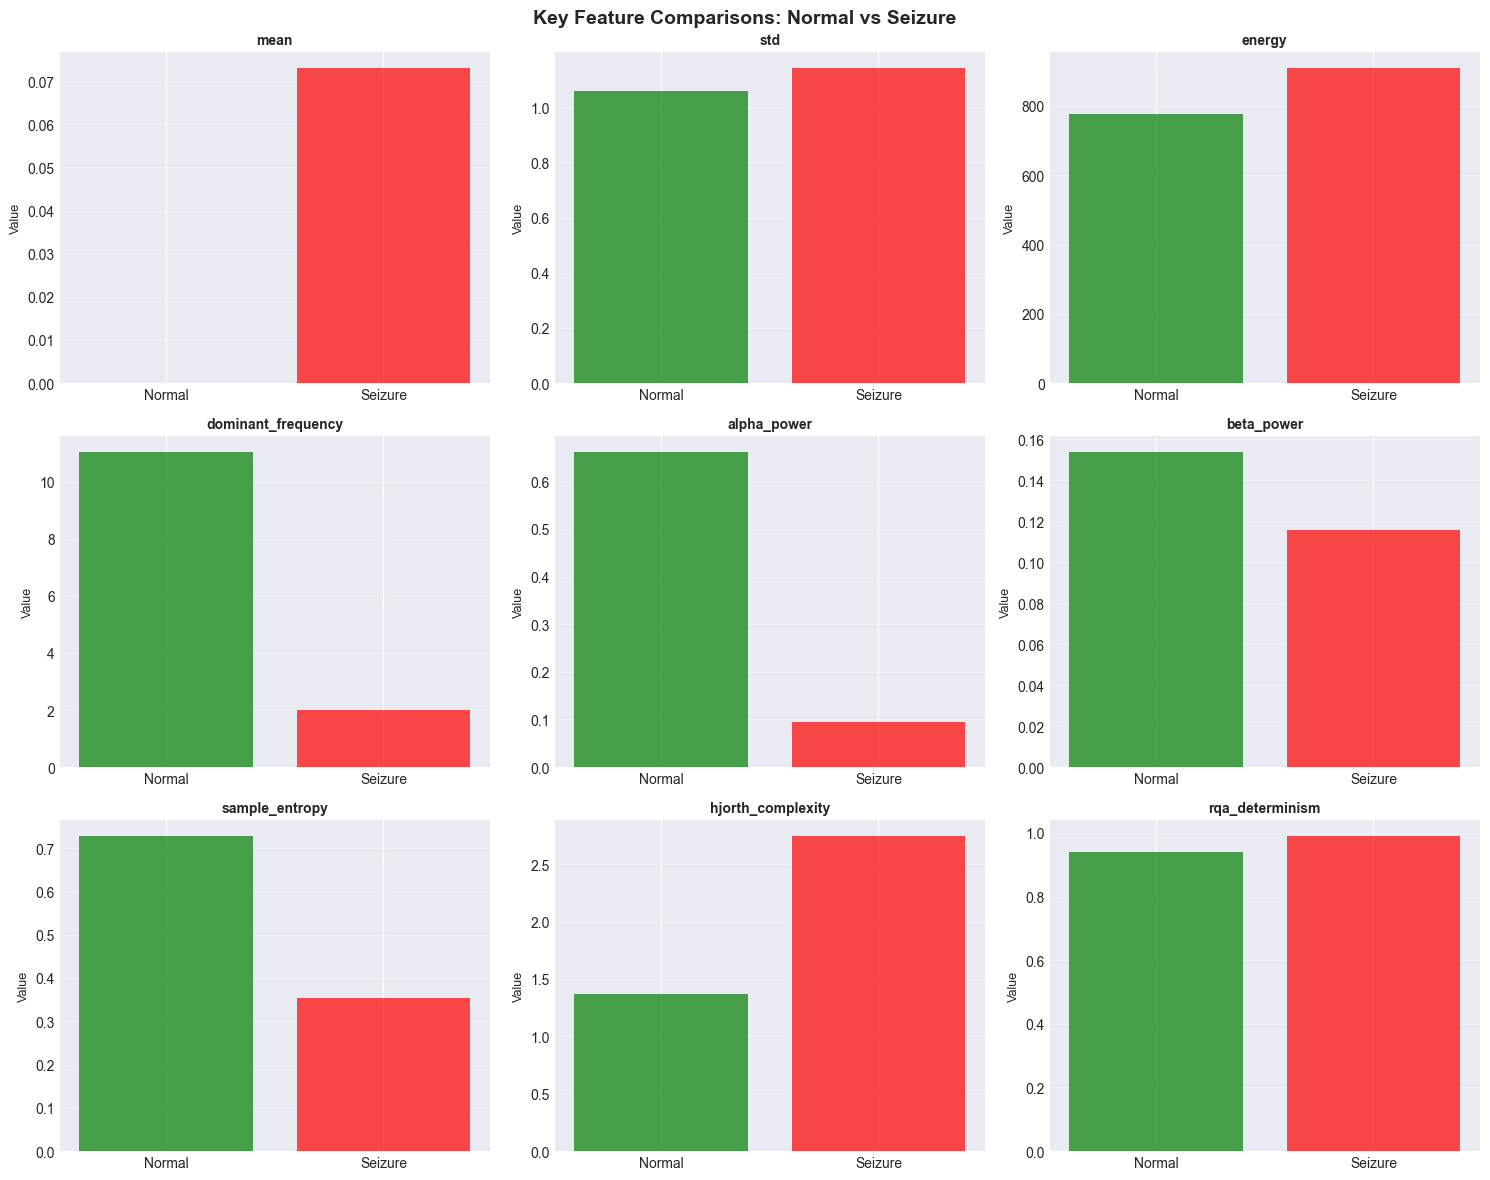

In [14]:
# Visualize key feature comparisons
print("\nCreating feature comparison visualizations...")

# Select key features to visualize
key_features = [
    'mean', 'std', 'energy',
    'dominant_frequency', 'alpha_power', 'beta_power',
    'sample_entropy', 'hjorth_complexity',
]

if FEATURE_CONFIG['include_rqa']:
    key_features.extend(['rqa_determinism', 'rqa_entropy'])

# Filter to available features
key_features = [f for f in key_features if f in all_features_seizure.keys()]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_features[:9]):
    seizure_val = all_features_seizure[feature]
    normal_val = all_features_normal[feature]
    
    axes[idx].bar(['Normal', 'Seizure'], [normal_val, seizure_val], 
                  color=['green', 'red'], alpha=0.7)
    axes[idx].set_title(feature, fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Value', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Key Feature Comparisons: Normal vs Seizure', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_comparison_samples.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# EXTRACT FEATURES FROM ALL DATA
# ============================================================================

In [15]:
def extract_features_batch(X, extractor, include_rqa=True, desc="Extracting"):
    """Extract features from multiple samples with progress bar"""
    features_list = []
    
    for signal in tqdm(X, desc=desc):
        features = extractor.extract_all(signal, include_rqa=include_rqa)
        features_list.append(features)
    
    # Convert to dataframe
    features_df = pd.DataFrame(features_list)
    
    return features_df

In [18]:
print("\n" + "="*80)
print("EXTRACTING FEATURES FROM ALL SAMPLES")
print("="*80)

# Extract features from training set
print("\nExtracting features from training set...")
X_train_features = extract_features_batch(
    X_train, extractor, 
    include_rqa=FEATURE_CONFIG['include_rqa'],
    desc="Training"
)

print(f"Training features: {X_train_features.shape}")


EXTRACTING FEATURES FROM ALL SAMPLES

Extracting features from training set...


Training: 100%|██████████| 5600/5600 [3:17:08<00:00,  2.11s/it]  


Training features: (5600, 74)


In [19]:
# Extract features from validation set
print("\nExtracting features from validation set...")
X_val_features = extract_features_batch(
    X_val, extractor,
    include_rqa=FEATURE_CONFIG['include_rqa'],
    desc="Validation"
)

print(f"Validation features: {X_val_features.shape}")


Extracting features from validation set...


Validation: 100%|██████████| 1200/1200 [41:34<00:00,  2.08s/it]

Validation features: (1200, 74)


In [ ]:
# # Save as CSV for inspection
# X_train_features.to_csv(FEATURES_DIR / 'X_train_features.csv', index=False)
# X_val_features.to_csv(FEATURES_DIR / 'X_val_features.csv', index=False)

In [21]:
# Extract features from test set
print("\nExtracting features from test set...")
X_test_features = extract_features_batch(
    X_test, extractor,
    include_rqa=FEATURE_CONFIG['include_rqa'],
    desc="Test"
)

print(f"Test features: {X_test_features.shape}")


Extracting features from test set...


Test: 100%|██████████| 1200/1200 [42:06<00:00,  2.11s/it]

Test features: (1200, 74)


In [22]:
print("\n" + "="*80)
print("SAVING EXTRACTED FEATURES")
print("="*80)


# Save as CSV for inspection
X_train_features.to_csv(FEATURES_DIR / 'X_train_features.csv', index=False)
X_val_features.to_csv(FEATURES_DIR / 'X_val_features.csv', index=False)
X_test_features.to_csv(FEATURES_DIR / 'X_test_features.csv', index=False)

# Save as numpy arrays for faster loading
np.save(FEATURES_DIR / 'X_train_features.npy', X_train_features.values)
np.save(FEATURES_DIR / 'y_train.npy', y_train)
np.save(FEATURES_DIR / 'X_val_features.npy', X_val_features.values)
np.save(FEATURES_DIR / 'y_val.npy', y_val)
np.save(FEATURES_DIR / 'X_test_features.npy', X_test_features.values)
np.save(FEATURES_DIR / 'y_test.npy', y_test)

# Save feature names
feature_names = X_train_features.columns.tolist()
with open(FEATURES_DIR / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))

# Save feature extractor configuration
config_df = pd.DataFrame([FEATURE_CONFIG])
config_df.to_csv(FEATURES_DIR / 'feature_config.csv', index=False)

print(f"\n Saved features to {FEATURES_DIR}/")
print(f"  - X_train_features: {X_train_features.shape}")
print(f"  - X_val_features: {X_val_features.shape}")
print(f"  - X_test_features: {X_test_features.shape}")
print(f"  - Feature names: {len(feature_names)} features")


SAVING EXTRACTED FEATURES

 Saved features to ..\data\processed\bonn\features/
  - X_train_features: (5600, 74)
  - X_val_features: (1200, 74)
  - X_test_features: (1200, 74)
  - Feature names: 74 features


In [ ]:
# ============================================================================
# FEATURE STATISTICS AND ANALYSIS
# ============================================================================

In [23]:
feature_stats = []

for feature_name in X_train_features.columns:
    # Get values for each class
    seizure_vals = X_train_features.loc[y_train == 1, feature_name]
    normal_vals = X_train_features.loc[y_train == 0, feature_name]
    
    stats = {
        'Feature': feature_name,
        'Seizure_Mean': seizure_vals.mean(),
        'Seizure_Std': seizure_vals.std(),
        'Normal_Mean': normal_vals.mean(),
        'Normal_Std': normal_vals.std(),
        'Mean_Diff': seizure_vals.mean() - normal_vals.mean(),
        'Std_Ratio': seizure_vals.std() / (normal_vals.std() + 1e-10)
    }
    
    # T-test for statistical significance
    from scipy import stats as scipy_stats
    t_stat, p_value = scipy_stats.ttest_ind(seizure_vals, normal_vals)
    stats['T_Statistic'] = t_stat
    stats['P_Value'] = p_value
    stats['Significant'] = p_value < 0.05
    
    feature_stats.append(stats)

feature_stats_df = pd.DataFrame(feature_stats)

In [24]:
# Sort by absolute mean difference
feature_stats_df = feature_stats_df.sort_values('Mean_Diff', key=lambda x: abs(x),  ascending=False)

print("\nTop 15 most discriminative features (by mean difference):")
print(feature_stats_df.head(15)[['Feature', 'Seizure_Mean', 'Normal_Mean', 'Mean_Diff', 'P_Value']])

# Save feature statistics
feature_stats_df.to_csv(FEATURES_DIR / 'feature_statistics.csv', index=False)
print("\nSaved feature statistics")


Top 15 most discriminative features (by mean difference):
                    Feature  Seizure_Mean  Normal_Mean   Mean_Diff  \
38   wavelet_level_0_energy    250.894330   390.095736 -139.201406   
46   wavelet_level_2_energy    247.162785   168.889524   78.273260   
42   wavelet_level_1_energy    206.724930   155.280534   51.444396   
50   wavelet_level_3_energy    152.036677   129.175570   22.861107   
60     wavelet_total_energy    887.844551   873.387598   14.456954   
13                   energy    694.000751   687.527926    6.472825   
34        alpha_delta_ratio      7.305631     2.026482    5.279149   
54   wavelet_level_4_energy     29.614906    28.317948    1.296959   
18       dominant_frequency      5.569928     4.434868    1.135060   
20        spectral_centroid      7.852654     6.813829    1.038826   
37      wavelet_level_0_std      2.588456     3.429068   -0.840612   
35         spectral_edge_95     17.209754    16.472163    0.737592   
6                     range    

In [ ]:
# ============================================================================
# FEATURE DISTRIBUTIONS
# ============================================================================

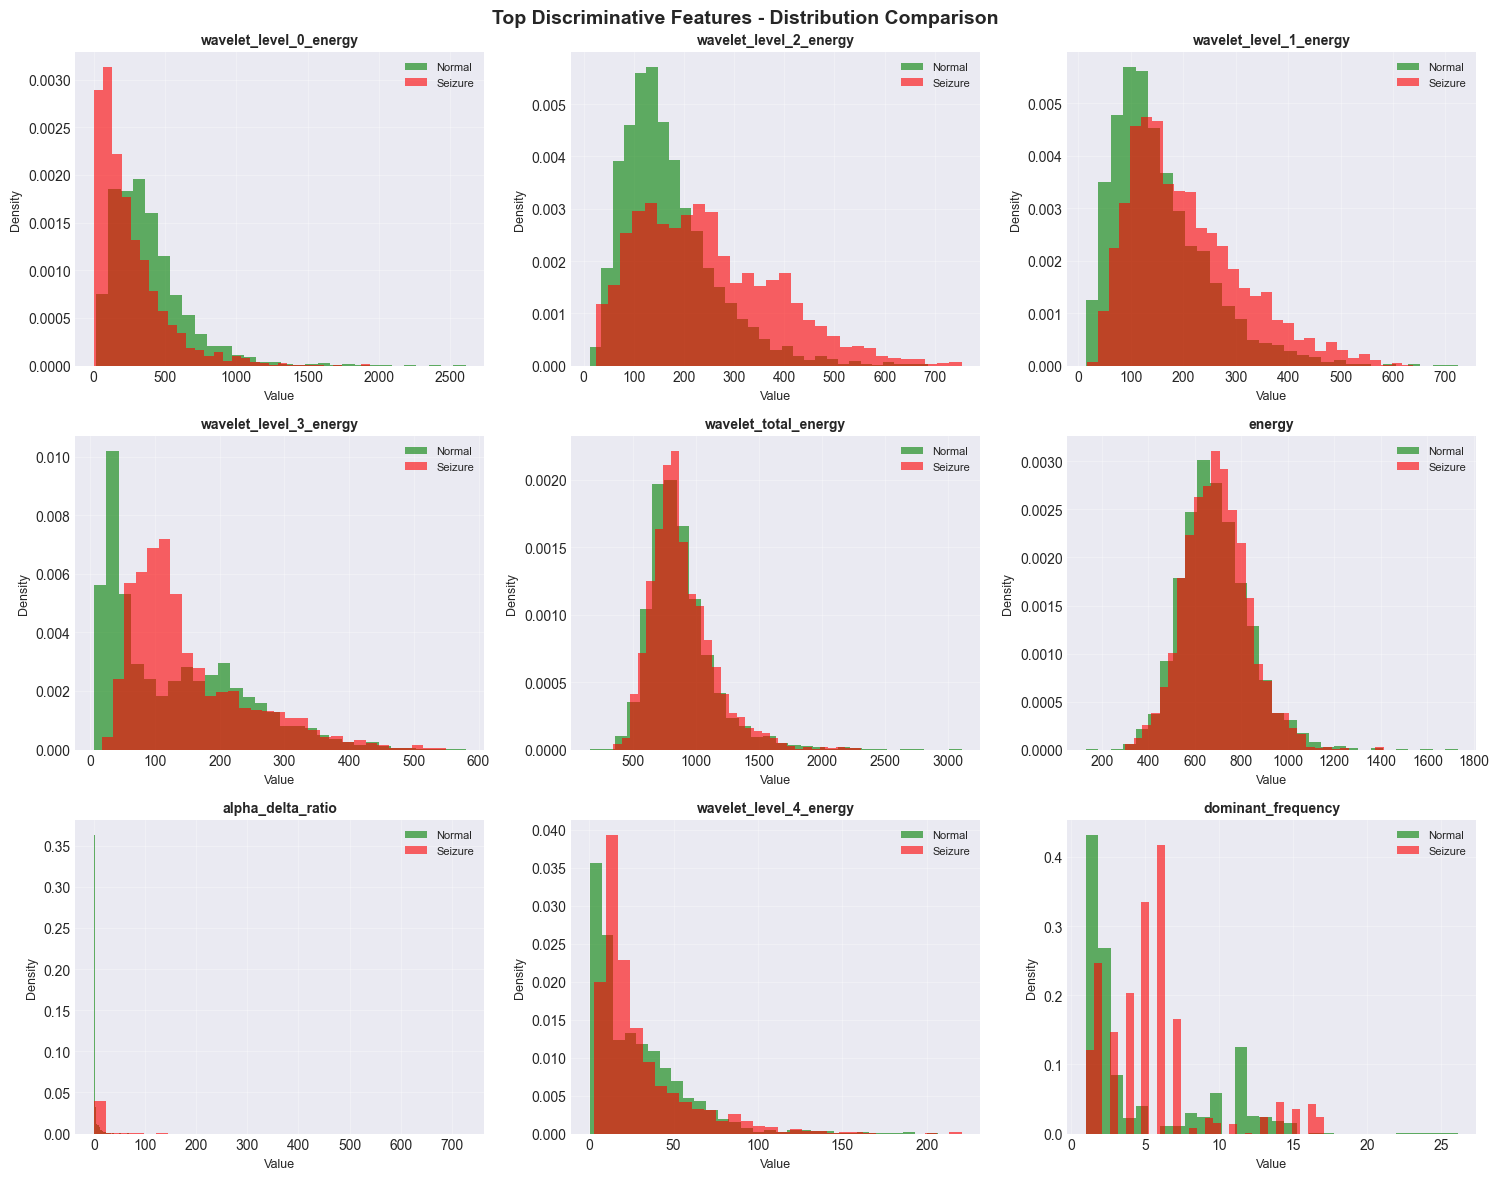

In [25]:
# Select top discriminative features to visualize
top_features = feature_stats_df.head(9)['Feature'].tolist()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    # Get data for each class
    seizure_data = X_train_features.loc[y_train == 1, feature]
    normal_data = X_train_features.loc[y_train == 0, feature]
    
    # Plot histograms
    axes[idx].hist(normal_data, bins=30, alpha=0.6, label='Normal', color='green', density=True)
    axes[idx].hist(seizure_data, bins=30, alpha=0.6, label='Seizure', color='red', density=True)
    
    axes[idx].set_title(feature, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value', fontsize=9)
    axes[idx].set_ylabel('Density', fontsize=9)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Top Discriminative Features - Distribution Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# FEATURE CORRELATION ANALYSIS
# ============================================================================

In [26]:
# Calculate correlation matrix
correlation_matrix = X_train_features.corr()

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.9):")
    print(pd.DataFrame(high_corr_pairs).head(10))
else:
    print("\nNo highly correlated feature pairs found (|r| > 0.9)")


Found 43 highly correlated feature pairs (|r| > 0.9):
  Feature1         Feature2  Correlation
0      std              var     0.996243
1      std              rms     0.999967
2      std           energy     0.996173
3      std            power     0.996173
4      std  hjorth_activity     0.996243
5      var              rms     0.996249
6      var           energy     0.999966
7      var            power     0.999966
8      var  hjorth_activity     1.000000
9      rms           energy     0.996244



Creating correlation heatmap...


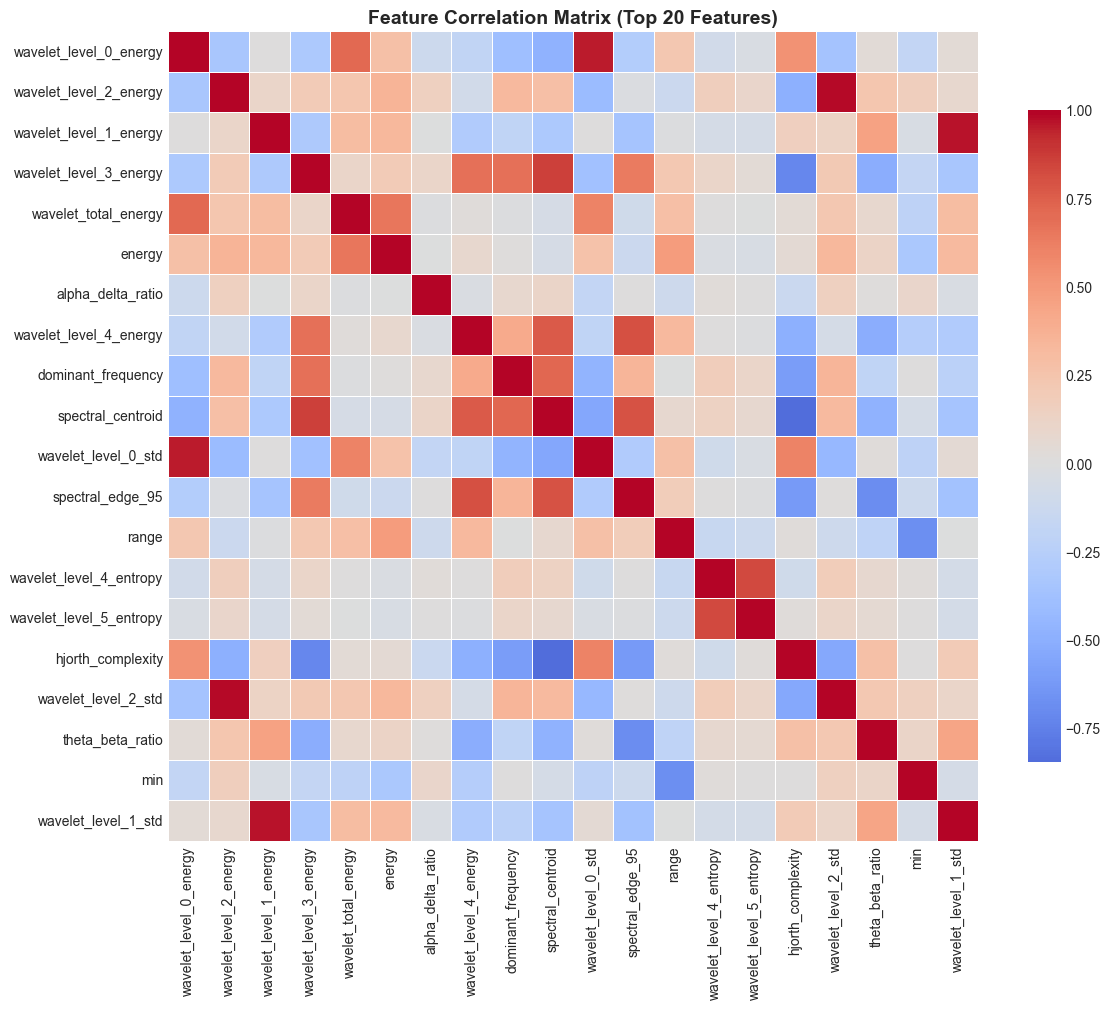

In [27]:
print("\nCreating correlation heatmap...")

# Select subset of features for visualization
n_features_to_show = min(20, len(X_train_features.columns))
top_features_for_corr = feature_stats_df.head(n_features_to_show)['Feature'].tolist()

# Create correlation matrix for selected features
subset_corr = X_train_features[top_features_for_corr].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(subset_corr, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Top 20 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# PRELIMINARY FEATURE IMPORTANCE
# ============================================================================

In [28]:
print("\nComputing feature importance using Random Forest...")

from sklearn.ensemble import RandomForestClassifier

# Train a random forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_features, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 most important features (Random Forest):")
print(feature_importance.head(15))


Computing feature importance using Random Forest...

Top 15 most important features (Random Forest):
                    Feature  Importance
55  wavelet_level_4_entropy    0.122610
59  wavelet_level_5_entropy    0.089730
72           hurst_exponent    0.078671
67           sample_entropy    0.064419
25              theta_power    0.046902
26     theta_relative_power    0.038545
70          hjorth_mobility    0.031772
68      approximate_entropy    0.030381
23              delta_power    0.028725
51  wavelet_level_3_entropy    0.026124
3                    median    0.021403
20        spectral_centroid    0.019937
28     alpha_relative_power    0.018365
24     delta_relative_power    0.018133
18       dominant_frequency    0.016946


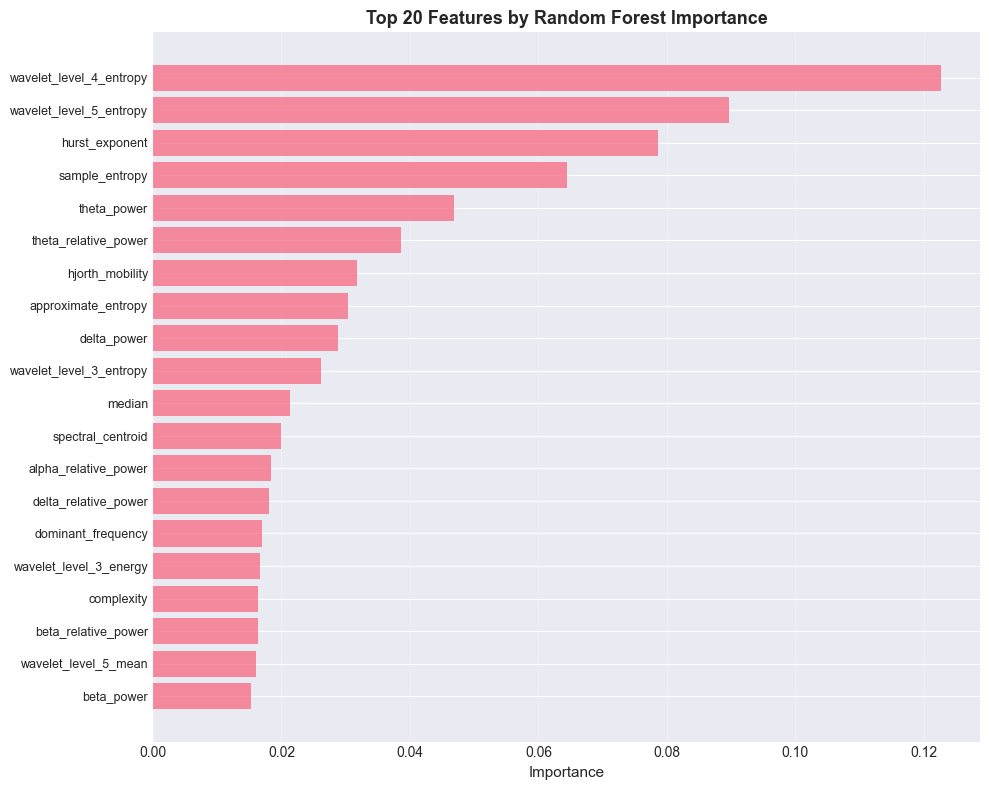

In [29]:
# Visualize top features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
top_features_imp = feature_importance.head(top_n)

ax.barh(range(top_n), top_features_imp['Importance'].values, alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_imp['Feature'].values, fontsize=9)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Top 20 Features by Random Forest Importance', 
            fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_importance.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# Save feature importance
feature_importance.to_csv(FEATURES_DIR / 'feature_importance.csv', index=False)